In [1]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy
import numpy as np
import cupy as cp
import math
import json
from PIL import Image, ImageDraw
from scipy.special import factorial

%run utils.ipynb

In [2]:
variant = 'RETINA'
config = Config(variant)

In [3]:
%%time
IMAGE_SIZE = -1
IMAGES = []
IMAGES_METADATA = []

with open(os.path.join(config.dataset_path, config.dataset_metadata_file_name)) as f:
    metadata = json.load(f)

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    if not image_fname.endswith('.png'):
        continue

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.width == IMAGE_SIZE or IMAGE_SIZE == -1
        IMAGE_SIZE = image.width
        assert image.mode == 'L'
        image_index = len(IMAGES)
        IMAGES.append(np.array(image).ravel())
        metadata_record = metadata[os.path.basename(image_fname)]
        metadata_record = np.rec.array([(image_fname, metadata_record.get('value', '?'))], dtype=[('file_name', 'object'), ('value', 'object')])
        IMAGES_METADATA.append(metadata_record)
        
    assert image.fp is None

assert len(IMAGES) == len(IMAGES_METADATA)
IMAGES = np.array(IMAGES)
IMAGES_METADATA = np.rec.array(np.concatenate(IMAGES_METADATA))
print(f'Loaded {len(IMAGES)} images')

  0%|          | 0/5002 [00:00<?, ?it/s]

Loaded 5000 images
CPU times: user 703 ms, sys: 67.8 ms, total: 771 ms
Wall time: 768 ms


In [4]:
device_marker = np.empty(1)
xp = cp.get_array_module(device_marker)

In [5]:
SENSOR_RECEPTIVE_FIELD_SIZE = 8
SENSOR_GROUP_SIZE = 4
RETINA_SIZE = 16


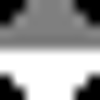
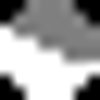
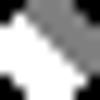
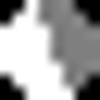
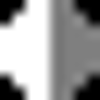
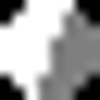
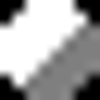
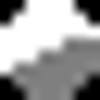
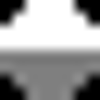
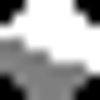
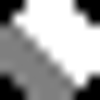
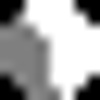
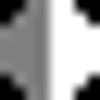
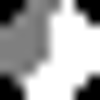
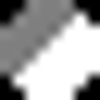
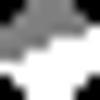

In [9]:
group_sensors_img = []
captions = []
steps = pow(SENSOR_GROUP_SIZE, 2)
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    draw.ellipse([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], outline=0, fill=127, width=0)
    angle = i * 360 / steps
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    group_sensors_img.append(canvas)
    captions.append(f'#{i} ({i // SENSOR_GROUP_SIZE}, {i % SENSOR_GROUP_SIZE})')

display_images_grid(list(map(lambda x: x.crop([0,0,SENSOR_RECEPTIVE_FIELD_SIZE,SENSOR_RECEPTIVE_FIELD_SIZE]).resize((100, 100)), group_sensors_img)), col_count=SENSOR_GROUP_SIZE, captions=captions)

# canvas = Image.new('L', (100, 100))
# draw = ImageDraw.Draw(canvas)
# draw.chord([0, 0, 100 - 1, 100 - 1], 0, 0 + 180, outline=255, fill=255)

# for i in range(steps):
#     angle = -i * 360 / steps
#     canvas2 = canvas.rotate(angle, resample=Image.Resampling.BICUBIC)
#     group_sensors_img.append(canvas2.resize((8, 8)))

#display_images(group_sensors_img)

In [192]:
group_sensors = xp.array(list(map(xp.array, group_sensors_img))).astype(float)
shape_save = group_sensors.shape
group_sensors = group_sensors.reshape(SENSOR_GROUP_SIZE*SENSOR_GROUP_SIZE, -1)
# Due to rough granularity count of positive pixels and negative may be not eqaul => equalize via weight
group_sensors[group_sensors==255] = 1
counts_of_positives = (group_sensors == 1).sum(axis=1)
counts_of_negatives = (group_sensors == 127).sum(axis=1)
white_image = xp.ones(group_sensors.shape[1])

for i, (p, n) in enumerate(zip(counts_of_positives, counts_of_negatives)):
    assert p > 0, (i, p)
    assert n > 0, (i, n)
    group_sensors[i][group_sensors[i] == 127] = -1 * (p / n)
    v = group_sensors[i] @ white_image
    assert xp.isclose(v, 0), v

group_sensors = group_sensors.reshape(shape_save)
group_sensors.shape, np.unique_counts(group_sensors)

((16, 128, 128),
 UniqueCountsResult(values=array([-1.36363636, -1.26086957, -1.16666667, -1.08      , -1.        ,
         0.        ,  1.        ]), counts=array([    44,    138,     48,     50,    104, 261312,    448])))

In [11]:
# group_sensors = xp.array(list(map(xp.array, group_sensors_img))).astype(float)
# group_sensors[group_sensors == 127] = -1
# group_sensors[group_sensors == 255] = 1
# group_sensors.shape, np.unique_counts(group_sensors)

((16, 128, 128),
 UniqueCountsResult(values=array([-1.,  0.,  1.]), counts=array([   384, 261312,    448])))

In [193]:
group_sensors_ones = (group_sensors.reshape(group_sensors.shape[0], -1) == 1).sum(axis=1)
group_sensors_ones, group_sensors_ones.mean(), group_sensors_ones.min(), group_sensors_ones.max(), group_sensors_ones.std()

(array([26, 27, 29, 28, 26, 28, 29, 27, 26, 29, 29, 30, 26, 30, 29, 29]),
 np.float64(28.0),
 np.int64(26),
 np.int64(30),
 np.float64(1.4142135623730951))


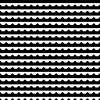
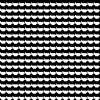
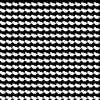
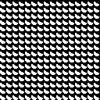
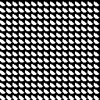
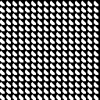
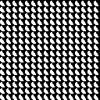
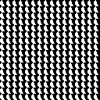
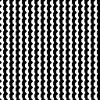
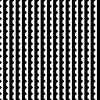
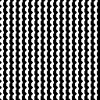
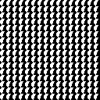
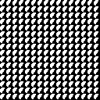
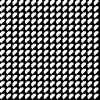
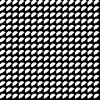
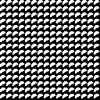
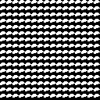
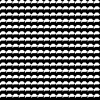
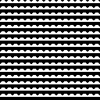
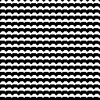
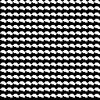
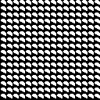
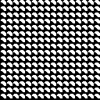
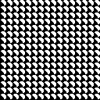
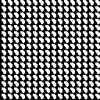
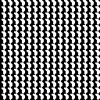
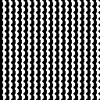
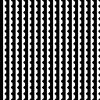
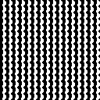
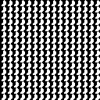
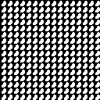
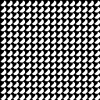
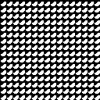
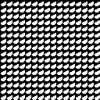
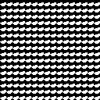
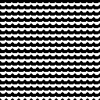

In [194]:
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
steps = 36 # 10 degreee
specific_samples_img = []
captions = []

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    angle = i * 360 / steps
    
    # coords = [-SENSOR_RECEPTIVE_FIELD_SIZE, -SENSOR_RECEPTIVE_FIELD_SIZE, SENSOR_RECEPTIVE_FIELD_SIZE*2 - 1, SENSOR_RECEPTIVE_FIELD_SIZE*2 - 1]
    # draw.chord(coords, angle, angle + 180, outline=255, fill=255)
    # draw.rectangle([SENSOR_RECEPTIVE_FIELD_SIZE, 0, sz, sz], fill=0)
    # draw.rectangle([0, SENSOR_RECEPTIVE_FIELD_SIZE, sz, sz], fill=0)
    
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    crop = canvas.crop([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE, SENSOR_RECEPTIVE_FIELD_SIZE])

    for x in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
        for y in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
            canvas.paste(crop, [x, y, x + SENSOR_RECEPTIVE_FIELD_SIZE, y + SENSOR_RECEPTIVE_FIELD_SIZE])
            
    specific_samples_img.append(canvas)
    captions.append(f'#{i}')

display_images_grid(list(map(lambda x: x.resize((100, 100)), specific_samples_img)), col_count=int(np.sqrt(steps)), captions=captions)

In [195]:
SPECIFIC_SAMPLES = xp.array(list(map(xp.array, specific_samples_img))).astype(float)
SPECIFIC_SAMPLES[SPECIFIC_SAMPLES==255] = 1
SPECIFIC_SAMPLES = SPECIFIC_SAMPLES.reshape(SPECIFIC_SAMPLES.shape[0], -1)
SPECIFIC_SAMPLES.shape, np.unique_counts(SPECIFIC_SAMPLES)

((36, 16384),
 UniqueCountsResult(values=array([0., 1.]), counts=array([331776, 258048])))

In [208]:
# single sensor occupies (RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE) ^ 2
# we have group of such sensors stacked under each other in a square fashion, hence SENSOR_GROUP_SIZE^2
# to cover all visual area we have RETINA_SIZE^2 of such groups
retina = xp.zeros((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
retina = retina.reshape((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1))

for y in range(RETINA_SIZE):
    for x in range(RETINA_SIZE):
        for g in range(pow(SENSOR_GROUP_SIZE, 2)):
            sensor_at_place = group_sensors[g]
            sensor_at_place = np.roll(sensor_at_place, y * SENSOR_RECEPTIVE_FIELD_SIZE, axis=0)
            sensor_at_place = np.roll(sensor_at_place, x * SENSOR_RECEPTIVE_FIELD_SIZE, axis=1)
            retina[y, x, g, :] = sensor_at_place.reshape(-1)

retina = retina.reshape((-1, pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
RETINA_POS = retina
RETINA_NEG = retina.copy()

RETINA_POS[RETINA_POS < 0] = 0

RETINA_NEG[RETINA_NEG > 0] = 0
#RETINA_NEG[RETINA_NEG < 0] = 1

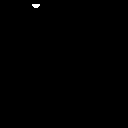

In [209]:
Image.frombytes('L', size=(sz, sz), data=RETINA_POS[4 * pow(SENSOR_GROUP_SIZE, 2)].astype(xp.uint8) * 255)

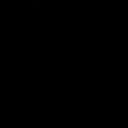

In [210]:
Image.frombytes('L', size=(sz, sz), data=RETINA_NEG.reshape((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1))[0,4,0].astype(xp.uint8) * 255)

In [211]:
assert xp.array_equal(xp.unique(SPECIFIC_SAMPLES), [0, 1])

specific_samples_sense_pos = RETINA_POS @ SPECIFIC_SAMPLES.T
specific_samples_sense_neg = RETINA_NEG @ SPECIFIC_SAMPLES.T
specific_samples_sense_pos = specific_samples_sense_pos.reshape(RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1)
specific_samples_sense_neg = specific_samples_sense_neg.reshape(RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1)
specific_samples_sense_ref = specific_samples_sense_pos.copy() # reference
assert specific_samples_sense_pos.shape == specific_samples_sense_neg.shape

# Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
# Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
# Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
# For specific samples situation is more straighforward, since is liminiscense is binary (0 or 1)

for y in range(specific_samples_sense_ref.shape[0]):
    for x in range(specific_samples_sense_ref.shape[1]):
        # Matrix of how each group of sensors (rows) perceives each of specific samples (columns)
        perceive_matrix = specific_samples_sense_ref[y, x]
        assert perceive_matrix.shape == (pow(SENSOR_GROUP_SIZE, 2), SPECIFIC_SAMPLES.shape[0])
        cond1 = (perceive_matrix.T / group_sensors_ones).T >= 0.5 # At least half of a positive area of each of sensors is activated

        perceive_matrix_pos = specific_samples_sense_pos[y, x]
        perceive_matrix_neg = xp.abs(specific_samples_sense_neg[y, x])
        assert perceive_matrix_pos.shape == perceive_matrix.shape
        assert perceive_matrix_neg.shape == perceive_matrix.shape

        cond2 = perceive_matrix_pos > perceive_matrix_neg # There is more activation on positive areas than on negative
        assert cond1.shape == cond2.shape
        specific_samples_sense_ref[y, x] = (cond1 & cond2).astype(float)

for i in range(SPECIFIC_SAMPLES.shape[0]):
    v = specific_samples_sense_ref[0, 0, :, i]
    print(f'{v} => {(v == 1).sum()}')

    for y in range(specific_samples_sense_ref.shape[0]):
        for x in range(specific_samples_sense_ref.shape[1]):
            assert xp.array_equal(v, specific_samples_sense_ref[y, x, :, i])

[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 7
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 8
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 8
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 7
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.] => 8
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.] => 8
[0. 0. 0. 

In [212]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image

In [267]:
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)

def perceive_images(images):
    sense_ress = []
    image_masks = images.copy()
    image_masks[image_masks > 0] = 1
    
    sense_area = (RETINA_POS @ image_masks.T).T # for check of illuminated area
    sense_level = (RETINA_POS @ images.T).T # for check of absolute illumination
    sense_neg_level = (RETINA_NEG @ images.T).T # for check of relative diff

    assert sense_area.shape == (len(images), pow(RETINA_SIZE, 2) * pow(SENSOR_GROUP_SIZE,2)), sense_area.shape
    assert sense_area.shape == sense_level.shape
    assert sense_area.shape == sense_neg_level.shape
    
    # Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
    # Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
    # Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
    for sense_area_i, sense_level_i, sense_neg_level_i in zip(sense_area, sense_level, sense_neg_level):
        sense_area_i = sense_area_i.reshape(-1, 16)
        cond1 = (sense_area_i / group_sensors_ones) >= 0.5 # At least half of a positive area of each of sensors is activated
        cond1 = cond1.reshape(-1,)
    
        sense_level_i = sense_level_i.reshape(-1, 16)
        sense_level_i[sense_level_i <= 0] = 1e-6 # to ease cond3
        cond2 = (sense_level_i > MINIMAL_ILLUMINATION_ABS_LEVEL * group_sensors_ones) # Illumination level of an area must exceed given threshold
        cond2 = cond2.reshape(-1,)
    
        sense_neg_level_i = xp.abs(sense_neg_level_i)
        sense_neg_level_i[sense_neg_level_i <= 0] = 1e-6 # to ease cond3
        cond3 = (sense_level_i.reshape(-1,) / sense_neg_level_i) >= MINIMAL_ILLUMINATION_DIFF_RATIO # Illumination of positive area must be > illumination of negative one
    
        sense_res = (cond1 & cond2 & cond3).astype(float)
        sense_ress.append(sense_res)

    return xp.array(sense_ress)

In [268]:
%%time
sense_ress = perceive_images(IMAGES)

CPU times: user 2min 20s, sys: 3.28 s, total: 2min 23s
Wall time: 15.5 s


In [298]:
sense_avg_bits_count = (sense_ress == 1).sum(axis=1) / sense_ress.shape[1]
np.round([sense_avg_bits_count.mean() * 100, sense_avg_bits_count.std() * 100], 2)

array([7.14, 1.55])

In [299]:
image_avg_bits_count = (IMAGES > 0).sum(axis=1) / IMAGES.shape[1]
np.round([image_avg_bits_count.mean() * 100, image_avg_bits_count.std() * 100], 2)

array([22.97,  5.76])

In [301]:
np.round(image_avg_bits_count.mean() / sense_avg_bits_count.mean(), 2)

np.float64(3.22)


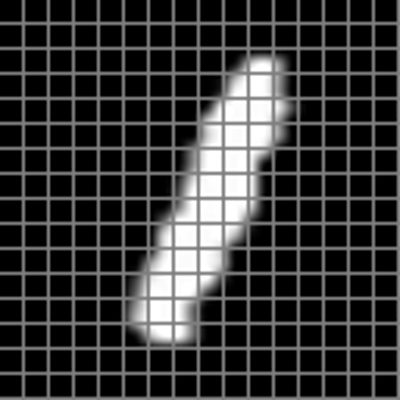
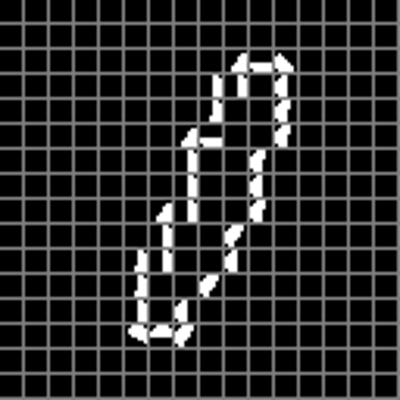

In [285]:
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)

image = IMAGES[0] # 10 - вертикальная единичка

image_mask = image.copy()
image_mask[image_mask > 0] = 1

sense_area = RETINA_POS @ image_mask # for check of illuminated area
sense_level = RETINA_POS @ image # for check of absolute illumination
sense_neg_level = RETINA_NEG @ image # for check of relative diff

sense_area, sense_level, sense_neg_level = [x.reshape(RETINA_SIZE, RETINA_SIZE, -1) for x in [sense_area, sense_level, sense_neg_level]]
assert sense_area.shape == sense_level.shape
assert sense_area.shape == sense_neg_level.shape
sense_res = sense_area.copy()

sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
sensed_image = np.zeros((sz, sz))

# Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
# Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
# Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
# For specific samples situation is more straighforward, since is liminiscense is binary (0 or 1)

for y in range(sense_area.shape[0]):
    for x in range(sense_area.shape[1]):
        # Matrix of how each group of sensors (rows) perceives each of specific samples (columns)
        perceive_vector_area = sense_area[y, x]
        assert perceive_vector_area.shape == (pow(SENSOR_GROUP_SIZE, 2),), perceive_vector_area.shape
        cond1 = (perceive_vector_area / group_sensors_ones).T >= 0.5 # At least half of a positive area of each of sensors is activated

        perceive_vector_level = sense_level[y, x].copy()
        assert xp.all(perceive_vector_level >= 0)
        perceive_vector_level[perceive_vector_level <= 0] = 1e-6 # to ease cond3
        assert xp.all(perceive_vector_level > 0), perceive_vector_level
        assert perceive_vector_level.shape == perceive_vector_area.shape
        cond2 = (perceive_vector_level > MINIMAL_ILLUMINATION_ABS_LEVEL * group_sensors_ones) # Illumination level of an area must exceed given threshold

        perceive_vector_neg_level = xp.abs(sense_neg_level[y, x])
        perceive_vector_neg_level[perceive_vector_neg_level <= 0] = 1e-6 # to ease cond3
        assert perceive_vector_neg_level.shape == perceive_vector_area.shape
        cond3 = (perceive_vector_level / perceive_vector_neg_level) >= MINIMAL_ILLUMINATION_DIFF_RATIO # Illumination of positive area must > illumination of negative one

        sense_vector = (cond1 & cond2 & cond3).astype(float)
        sense_res[y, x] = sense_vector

        if xp.any(sense_vector > 0):
            # Find most similar reaction among specific samples of reactions
            a = sense_vector
            b = specific_samples_sense_ref[y, x, :]
            sense_vector_cos_sim = (a @ b)/(xp.linalg.norm(a) * xp.linalg.norm(b, axis=0))
            best_i = xp.argmax(sense_vector_cos_sim)
            most_similar_specific_sample = SPECIFIC_SAMPLES[best_i].reshape((sz, sz))
            srfs = SENSOR_RECEPTIVE_FIELD_SIZE
            np.copyto(sensed_image[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs], most_similar_specific_sample[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs])

    #     if y == 4 and x == 8:
    #         break

    # if y == 4 and x == 8:
    #         break

images = [lay_grid(Image.frombytes('L', size=(sz, sz), data=image), SENSOR_RECEPTIVE_FIELD_SIZE), 
          lay_grid(Image.frombytes('L', size=(sz, sz), data=(sensed_image * 255).astype(np.uint8)), SENSOR_RECEPTIVE_FIELD_SIZE)]
display_images(list(map(lambda x: x.resize((400, 400)), images)))

In [286]:
np.array_equal(sense_res.reshape(-1), sense_ress[0].reshape(-1))

True

In [231]:
(image > 0).sum() / image.size

np.float64(0.13043212890625)

In [232]:
z = image.reshape(128, 128)
i = 4
j = 8
zpart = z[i*8:(i+1)*8,j*8:(j+1)*8]
zpart, zpart.shape

(array([[195, 232, 255, 255, 255, 255, 255, 246],
        [205, 235, 255, 255, 255, 255, 255, 246],
        [212, 237, 255, 255, 255, 255, 255, 246],
        [218, 239, 255, 255, 255, 255, 255, 246],
        [223, 241, 254, 255, 255, 255, 255, 246],
        [226, 243, 254, 255, 255, 255, 255, 246],
        [229, 244, 254, 255, 255, 255, 255, 246],
        [231, 244, 254, 255, 255, 255, 255, 246]], dtype=uint8),
 (8, 8))

In [233]:
aaa = RETINA_POS.reshape(16,16,16,-1)[i,j,:]
bbb = RETINA_NEG.reshape(16,16,16,-1)[i,j,:]
aaa.shape

(16, 16384)

In [234]:
aaa2 = aaa.reshape(16,128,128)
aaa2 = aaa2[:,i*8:(i+1)*8,j*8:(j+1)*8]
aaa2 = aaa2.reshape(16,-1)
aaa2 @ zpart.reshape(-1)

array([6510., 6678., 7159., 6904., 6394., 6904., 7161., 6666., 6478.,
       7278., 7339., 7614., 6594., 7612., 7345., 7303.])

In [235]:
bbb2 = bbb.reshape(16,128,128)
bbb2 = bbb2[:,i*8:(i+1)*8,j*8:(j+1)*8]
bbb2 = bbb2.reshape(16,-1)
bbb2 @ zpart.reshape(-1)

array([-6478.        , -6814.8       , -7349.60869565, -7098.        ,
       -6594.        , -7098.        , -7347.08695652, -6827.76      ,
       -6510.        , -7199.56521739, -7122.65217391, -7328.18181818,
       -6394.        , -7330.90909091, -7115.08695652, -7168.04347826])

In [236]:
ppp = (aaa2 @ zpart.reshape(-1)) / (bbb2 @ zpart.reshape(-1))
ppp,  (ppp >= MINIMAL_ILLUMINATION_DIFF_RATIO).reshape(4,-1)

(array([-1.0049398 , -0.97992604, -0.97406546, -0.97266836, -0.9696694 ,
        -0.97266836, -0.97467201, -0.97630848, -0.99508449, -1.01089438,
        -1.03037462, -1.03900261, -1.03127932, -1.03834325, -1.03231346,
        -1.01882753]),
 array([[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]]))